In [1]:
# import math
import pickle
import pandas as pd
# from pathlib import Path
import h5py
import os
import random

import PIL
import PIL.Image
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

2025-03-22 18:48:24.318864: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 18:48:24.319417: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 18:48:24.321350: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 18:48:24.327359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 18:48:24.337304: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
test_path = "/home/user/Education/ML/lab1/lab1/lab4/test"
mat_path = test_path + "/digitStruct.mat"

In [3]:
train_path = "/home/user/Education/ML/lab1/lab1/lab4/train"
train_mat_path = train_path + "/digitStruct.mat"

## Загрузка датасета из digitStruct.mat файла
Данная функция извлекает в формате датафрейма информацию о каждом изображении, такую как название файла, число, размеры рамки, в котором содержится число.

In [4]:
def mat_to_dataset(mat_path, image_folder):
    """Convert .mat file to a DataFrame with grouped labels and bounding boxes for each image."""
    df = pd.DataFrame(columns=('filename', 'value', 'digits', 'length', 'width', 'height', 'box'))
    
    with h5py.File(mat_path, mode='r') as f:
        # Preload all file names
        file_names = [''.join(chr(c[0]) for c in f[f['digitStruct']['name'][i, 0]][:]) 
                     for i in range(len(f['digitStruct']['name']))]
        
        # Preload all bounding boxes
        bboxes = []
        for i in range(len(f['digitStruct']['bbox'])):
            box_i = f['digitStruct']['bbox'][i, 0]
            bbox = {key: [] for key in ['label', 'left', 'top', 'width', 'height']}
            for key in bbox.keys():
                attr = f[box_i][key]
                bbox[key] = ([int(f[attr[index, 0]][0, 0]) for index in range(attr.shape[0])] 
                            if attr.shape[0] > 1 else [int(attr[0, 0])])
            bboxes.append(bbox)

        # Process all preloaded data
        for i, (filename, bbox) in enumerate(zip(file_names, bboxes)):
            # Reset bounding box coordinates for each new image
            left = top = 999999
            right = bottom = 0
            digits = []
            
            # Process the digits and bounding boxes
            for digit, l, t, w, h in zip(bbox['label'], bbox['left'], bbox['top'], 
                                       bbox['width'], bbox['height']):
                # digit = 0 if digit == 10 else digit
                left = min(l, left)
                top = min(t, top)
                right = max(l + w, right)
                bottom = max(t + h, bottom)
                digits.append(digit)

            # Process the image directly without checking previous state
            img_path = os.path.join(image_folder, filename)
            
            if os.path.isfile(img_path):
                with PIL.Image.open(img_path) as img:
                    width, height = img.size
                    df.loc[len(df)] = [
                        filename,
                        int("".join(map(str, digits))),
                        digits,
                        len(digits),
                        width,
                        height,
                        [left, top, right, bottom]
                    ]
            else:
                print(f"\nWarning: Could not find image file: {img_path}")

            if (i + 1) % 100 == 0:  # Print progress every 100 images
                print(f'Processing {i + 1}/{len(file_names)} records...', end='\r')

    print(f'\nProcessed {len(file_names)} records.')
    return df

## Загрузка датасета из датафрейма с изображениями

load_dataset - загружает датасет, обрезает изображение по рамке, в котором находится число

resize_with_padding - обрезка изображения так, чтобы оно не сжималось, а сохраняло свои пропорции

augumention - создает копию изображению, но с рандомным сдвигом, для увеличения выборки

In [5]:
def resize_with_padding(image, target_size=(64, 64)):
    old_size = image.size
    
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = (int(old_size[0] * ratio), int(old_size[1] * ratio))
    
    image = image.resize(new_size, PIL.Image.LANCZOS)
    
    mean_color = tuple(map(int, np.mean(np.array(image), axis=(0, 1))))

    new_image = PIL.Image.new("RGB", target_size, color=mean_color)
    new_image.paste(image, ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2))
    
    return new_image

In [6]:
def augumention(im):
    left = random.randint(0, 10)
    top = random.randint(0, 10)
    right = left + 54
    bottom = top + 54
    
    return im.crop((left, top, right, bottom)).resize([64, 64], PIL.Image.Resampling.LANCZOS)

In [7]:
def load_dataset(df, folder, to_rgb, with_aug=True):
    dataset = np.ndarray([(len(df) * 2) if with_aug else len(df), 64, 64], dtype='float32')
    labels = np.zeros([(len(df) * 2) if with_aug else len(df), 5], dtype=int)
    for i in range(len(df)):
        filename = df.loc[i, 'filename']
        fullname = os.path.join(folder, filename)
        im = PIL.Image.open(fullname)
        
        digits = df.loc[i, 'digits']
        box = df.loc[i, 'box']
     
        if isinstance(box, str):
            box = eval(box)

        for j in range(min(len(digits), 5)): 
            labels[i, j] = digits[j]
            if with_aug:
                labels[i * 2, j] = digits[j]

        if len(digits) > 5:
            print(f'Warning: Image {i} has more than 5 digits. Only the first 5 digits will be used.')

        if len(box) == 4: 
            left, top, width, height = box
        else:
            raise ValueError(f"Box format is incorrect for index {i}: {box}")
            
        im_left, im_top = left, top
        im_width, im_height = width, height
      
        im_top = max(0, np.floor(im_top - 0.2 * im_height))
        im_left = max(0, np.floor(im_left - 0.2 * im_width))
        im_bottom = min(im.size[1], np.ceil(im_top + 1.2 * im_height))
        im_right = min(im.size[0], np.ceil(im_left + 1.2 * im_width))
       
        im = resize_with_padding(im.crop((im_left, im_top, im_right, im_bottom)))
        if with_aug:
            aug_im = augumention(im)

        if to_rgb:
            im = np.array(im, dtype='float32') / 255.0
            dataset[i, :, :, :] = im
            if with_aug:
                aug_im = np.array(aug_im, dtype='float32') / 255.0
                dataset[i * 2, :, :, :] = aug_im
        else:
            im = np.array(im.convert('L'), dtype='float32') / 255.0
            dataset[i, :, :] = im
            if with_aug:
                aug_im = np.array(aug_im.convert('L'), dtype='float32') / 255.0
                dataset[i * 2, :, :] = aug_im
            
    return dataset, labels

In [8]:
def save_to_pickle(dataset, labels, filename):
    with open(f'{filename}.pickle', 'wb') as f:
        pickle.dump((dataset, labels), f)

In [9]:
def load_pickle(filename):
    with open(f'{filename}.pickle', 'rb') as f:
        dataset, labels = pickle.load(f)
    return dataset, labels

In [10]:
# datasets = mat_to_dataset(train_mat_path, train_path)
# dataset, labels = load_dataset(datasets, train_path, False)
# save_to_pickle(dataset, labels, "train_data_fix_with_padding_aug_1")

In [11]:
# datasets = mat_to_dataset(mat_path, test_path)
# dataset, labels = load_dataset(datasets, test_path, False, False)
# save_to_pickle(dataset, labels, "test_data_fix_with_padding_1")

## Предобработка датасета
Разделяем выборку на обучающую и валидационную, приводим к нужному виду

In [12]:
def preprocess_data(prefix, to_rgb):
    channels = 3 if to_rgb else 1
    x_test, y_test = load_pickle(f"test_data_fix_with_padding_{channels}")
    x_train, y_train = load_pickle(f"train_data_fix_with_padding_{prefix}_{channels}")

    print("Test dataset shape: ", x_test.shape, y_test.shape)
    print("Total train dataset shape: ", x_train.shape, y_train.shape)

    x_train, x_val, y_train, y_val = train_test_split(
        x_train,
        y_train,
        test_size=0.2,
        random_state=42
    )

    print("Train dataset shape after split: ", x_train.shape, y_train.shape)
    print("Validation dataset shape after split: ", x_val.shape, y_val.shape)

    x_train = x_train.reshape((len(x_train), 64, 64, channels))
    x_val = x_val.reshape((len(x_val), 64, 64, channels))
    x_test = x_test.reshape((len(x_test), 64, 64, channels))

    return x_train, x_val, x_test, y_train, y_val, y_test

In [13]:
def transform_labels(labels):
    num_samples = len(labels)
    num_classes = 11
    
    dig0_arr = np.zeros((num_samples, num_classes))
    dig1_arr = np.zeros((num_samples, num_classes))
    dig2_arr = np.zeros((num_samples, num_classes))
    dig3_arr = np.zeros((num_samples, num_classes))
    dig4_arr = np.zeros((num_samples, num_classes))
    
    for i, label in enumerate(labels):
        dig0_arr[i] = tf.keras.utils.to_categorical(label[0], num_classes)
        dig1_arr[i] = tf.keras.utils.to_categorical(label[1], num_classes)
        dig2_arr[i] = tf.keras.utils.to_categorical(label[2], num_classes)
        dig3_arr[i] = tf.keras.utils.to_categorical(label[3], num_classes)
        dig4_arr[i] = tf.keras.utils.to_categorical(label[4], num_classes)
    
    return [dig0_arr, dig1_arr, dig2_arr, dig3_arr, dig4_arr]

In [14]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocess_data("aug", False)

Test dataset shape:  (13068, 64, 64) (13068, 5)
Total train dataset shape:  (66804, 64, 64) (66804, 5)
Train dataset shape after split:  (53443, 64, 64) (53443, 5)
Validation dataset shape after split:  (13361, 64, 64) (13361, 5)


In [15]:
y_test

array([[ 5,  0,  0,  0,  0],
       [ 2,  1, 10,  0,  0],
       [ 6,  0,  0,  0,  0],
       ...,
       [ 1,  3,  6,  0,  0],
       [ 2,  2,  7,  0,  0],
       [ 6,  7,  0,  0,  0]])

In [16]:
y_train = transform_labels(y_train)
y_test = transform_labels(y_test)
y_val = transform_labels(y_val)

In [17]:
from tensorflow.keras.layers import Input, Conv2D,AveragePooling2D, GlobalAveragePooling2D, MaxPool2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.models import Model

img_rows, img_cols, img_channels = 64, 64, 1  # Размер изображения
nb_classes = 11  # 10 цифр + 1 класс "пусто"
num_digits = 5  # Количество цифр в одном изображении

# Входной слой
inputs = Input(shape=(img_rows, img_cols, img_channels))

# Блок 1
x = Conv2D(64, (3, 3), padding="same", use_bias=False)(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2))(x)

# Блок 2
x = Conv2D(128, (3, 3), padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2))(x)

# Блок 3
x = Conv2D(256, (3, 3), padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2))(x)

# Блок 4
x = Conv2D(512, (3, 3), padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2))(x)

# Глобальный усредненный пулинг
x = GlobalAveragePooling2D()(x)

# Полносвязный слой
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
# Финальные выходы для 5 цифр
outputs = []

for i in range(5):
    outputs.append(Dense(nb_classes, activation='softmax', name=f'digit_{i}')(x))

# Создаем модель
model = Model(inputs=inputs, outputs=outputs)

# Выводим summary модели
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        576 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     73,728 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    294,912 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 256) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 512) │  1,179,648 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 4, 512) │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                 

 Total params: 1,698,167 (6.48 MB)

 Trainable params: 1,696,247 (6.47 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [18]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy', 'accuracy'])

In [34]:
def show_history_plot(history):
    fig = plt.figure(figsize=(15, 4))

    # График точности (accuracy)
    fig.add_subplot(121)
    # for i in range(5):
    plt.plot(history.history[f'digit_0_accuracy'])
    plt.plot(history.history[f'val_digit_0_accuracy'])
    # plt.plot(history.history['val_accuracy'], '--', color='black', linewidth=1.5)  # Валидационная общая
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.title('Training accuracy for the first digit')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')

    # График ошибки (loss)
    fig.add_subplot(122)
    # for i in range(5):
    plt.plot(history.history[f'digit_0_loss'])
    plt.plot(history.history[f'val_digit_0_loss'])
    # plt.plot(history.history['val_loss'], '--', color='black', linewidth=1.5)  # Валидационная общая
    plt.legend(['Training loss', 'Validation loss'])
    plt.title('Training loss for the first digit')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')

    plt.show()

In [20]:
history = model.fit(
    x_train, y_train, 
    batch_size=64, 
    epochs=10, 
    validation_data=(x_val, y_val)
)

Epoch 1/10
836/836 ━━━━━━━━━━━━━━━━━━━━ 463s 551ms/step - digit_0_accuracy: 0.4347 - digit_0_loss: 1.5936 - digit_1_accuracy: 0.3442 - digit_1_loss: 1.8411 - digit_2_accuracy: 0.7131 - digit_2_loss: 1.1669 - digit_3_accuracy: 0.9538 - digit_3_loss: 0.2906 - digit_4_accuracy: 0.9921 - digit_4_loss: 0.0373 - loss: 4.9295 - val_digit_0_accuracy: 0.4616 - val_digit_0_loss: 1.5421 - val_digit_1_accuracy: 0.3786 - val_digit_1_loss: 1.8201 - val_digit_2_accuracy: 0.7173 - val_digit_2_loss: 1.1939 - val_digit_3_accuracy: 0.9588 - val_digit_3_loss: 0.2560 - val_digit_4_accuracy: 0.9998 - val_digit_4_loss: 0.0024 - val_loss: 4.8141
Epoch 2/10
836/836 ━━━━━━━━━━━━━━━━━━━━ 487s 583ms/step - digit_0_accuracy: 0.5216 - digit_0_loss: 1.3959 - digit_1_accuracy: 0.4179 - digit_1_loss: 1.6568 - digit_2_accuracy: 0.7254 - digit_2_loss: 1.0158 - digit_3_accuracy: 0.9591 - digit_3_loss: 0.2263 - digit_4_accuracy: 0.9997 - digit_4_loss: 0.0047 - loss: 4.2994 - val_digit_0_accuracy: 0.2715 - val_digit_0_loss

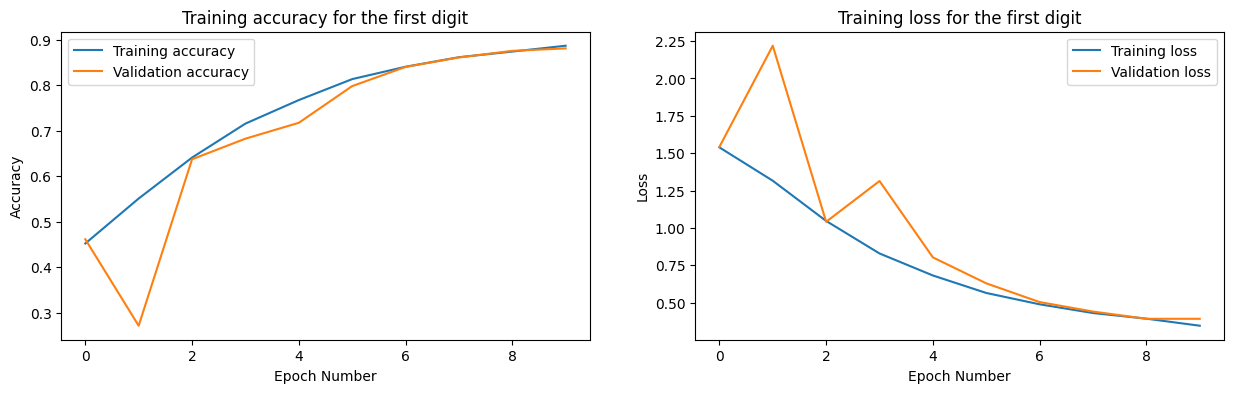

In [35]:
show_history_plot(history)

In [21]:
model.evaluate(x_test, y_test)
# print('Classification accuracy on test set: ', test_acc)

409/409 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - digit_0_accuracy: 0.7362 - digit_0_loss: 0.8530 - digit_1_accuracy: 0.6051 - digit_1_loss: 1.2662 - digit_2_accuracy: 0.8285 - digit_2_loss: 0.8845 - digit_3_accuracy: 0.9883 - digit_3_loss: 0.1372 - digit_4_accuracy: 0.9998 - digit_4_loss: 0.0038 - loss: 3.1447


[3.111164093017578,
 0.8455580472946167,
 1.2432467937469482,
 0.8819838762283325,
 0.13694901764392853,
 0.0036479628179222345,
 0.7372972369194031,
 0.619911253452301,
 0.8278236985206604,
 0.9884450435638428,
 0.9998469352722168]

## Выводы

По сравнению с реализованными ранее моделями, обученными на notMNIST датасете точность сильно уменьшилась. Это связанно с тем, что реальные данные гораздо сложнее и в них гораздо больше помех, шума, признаков. Модель стала труднее обучаться

## Сохранение модели для мобильного приложения

In [74]:
# model = tf.keras.models.load_model("model2.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model3.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdhxytkux/assets


INFO:tensorflow:Assets written to: /tmp/tmpdhxytkux/assets


Saved artifact at '/tmp/tmpdhxytkux'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='keras_tensor_48')
Output Type:
  List[TensorSpec(shape=(None, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)]
Captures:
  135198375966144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135198533042944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135198533043648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135198375965088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135198375964736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135198375467136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135198375881536: TensorSpec(shape=(), dtype=tf.res

W0000 00:00:1742152249.383330   40657 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1742152249.383378   40657 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2025-03-16 20:10:49.383702: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdhxytkux
2025-03-16 20:10:49.385122: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-16 20:10:49.385130: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpdhxytkux
2025-03-16 20:10:49.397027: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-03-16 20:10:49.400160: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-16 20:10:49.481358: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpdhxytkux
2025-03-16 20:10:49.501789: I tensorflow/cc/saved_model/loader.cc